In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import subprocess

import scipy.signal
from nistats import hemodynamic_models
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize

normalize_1d = lambda  x: normalize(x[:,np.newaxis], axis=0).ravel()

path_root = os.environ.get('DECIDENET_PATH')
path_code = os.path.join(path_root, 'code')
if path_code not in sys.path:
    sys.path.append(path_code)

In [2]:
# Directory for PPI analysis
path_out = os.path.join(path_root, 
                        'data/main_fmri_study/derivatives/ppi')
os.makedirs(path_out, exist_ok=True)

# Timeseries directory
path_timeries = os.path.join(path_out, 'timeseries')

# Load timeseries
time_series_all = np.load(os.path.join(path_timeries, 'time_series_clean_all.npy'))

n_volumes, t_r = 730, 2

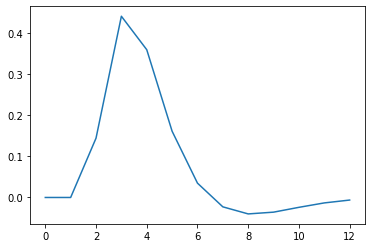

In [3]:
hrf_duration = 26

hrf_spm = hemodynamic_models.spm_hrf(
    t_r, 
    oversampling=1, 
    time_length=hrf_duration, 
    onset=0.0
    )

plt.plot(hrf_spm)

In [4]:
def dct_basis(n, k):
    '''Creates basis functions for Discrete Cosine Transform (DCT).'''
    C = np.zeros((n, k))
    for i in range(k):
        C[:, i] = np.sqrt(2 / n) * np.cos(np.pi * np.arange(n) * i / n)
    return C

X = dct_basis(n_volumes, n_volumes)

In [5]:
def convolve(signal, t_r=2):
    
    n_volumes = len(signal)
    onsets = np.zeros((3, n_volumes))
    for vol, amplitude in enumerate(signal):
        onsets[:, vol] = (vol * t_r, 0, amplitude)

    signal_bold = hemodynamic_models.compute_regressor(
        onsets,                             # input signal
        'spm',                              # hrf type
        np.arange(0, n_volumes * t_r, t_r), # frame times
        oversampling=50,     
        fir_delays=None)[0].ravel()

    return signal_bold

In [6]:
HX = np.zeros(X.shape)

for i, xi in enumerate(X):
    HX[:, i] = convolve(xi)

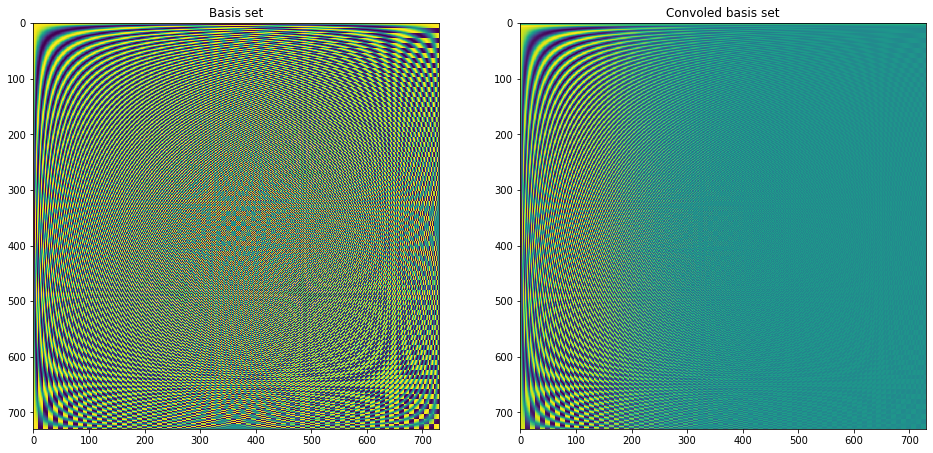

In [7]:
fig, ax = plt.subplots(figsize=(16, 8), ncols=2)

ax[0].imshow(X)
ax[0].set_title('Basis set')
ax[1].imshow(HX)
ax[1].set_title('Convoled basis set')

plt.show()

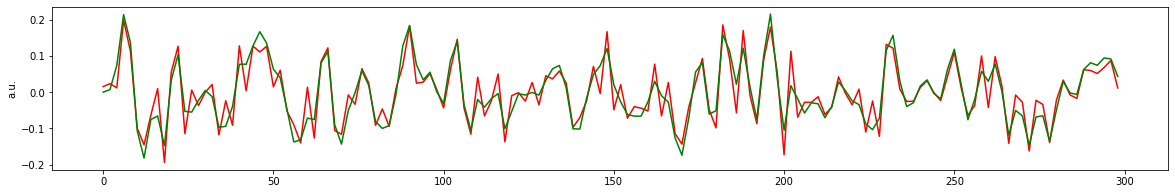

In [12]:
solver = Ridge(
    alpha=0.00001,
    solver='lsqr',
    fit_intercept=False,
    normalize=False,
    max_iter=1000
    )

y_bold = time_series_all[0, 0, :, 0]
solver.fit(HX, y_bold)

y_neur = np.matmul(X, solver.coef_) 
y_bold_recreated = convolve(y_neur)

# Plotting
fig, ax = plt.subplots(figsize=(20, 3), facecolor='w', sharex=True)
ax.plot(np.arange(0, 300, 2), normalize_1d(y_bold[:150]), 'r', label='BOLD')
ax.plot(np.arange(0, 300, 2), normalize_1d(y_bold_recreated[:150]), 'g', label='BOLD regenerated')
ax.set_ylabel('a.u.')

plt.show()

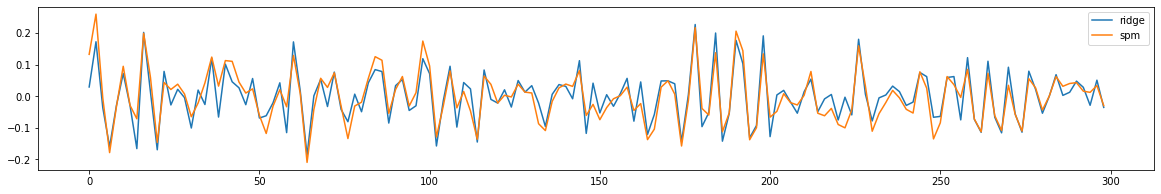

In [13]:
from scipy.io import loadmat
y_neur_spm = loadmat('matlab/neural.mat')['result'].flatten()

fig, ax = plt.subplots(figsize=(20, 3))

ax.plot(np.arange(0, 300, 2), normalize_1d(y_neur[:150]), label='ridge')
ax.plot(np.arange(0, 300, 2), normalize_1d(y_neur_spm[:150]), label='spm')
ax.legend()